In [1]:
# import numpy as np
# import pandas as pd

# import os
# for dirname, _, filenames in os.walk('/kaggle/input/immunoquest1/Dataset/Dataset/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


In [2]:
import numpy as np
import pandas as pd
import torch
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models
from PIL import Image
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_dir = "/kaggle/input/immunoquest1/Dataset/Dataset/train/"
val_dir = "/kaggle/input/immunoquest1/Dataset/Dataset/val/"

In [4]:
transform = transforms.Compose([
    transforms.RandomResizedCrop((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225])
])

In [5]:
train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)

In [6]:
batch_size=64
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=4)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True,num_workers=4)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s]


In [8]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)

In [9]:
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

model = model.to(device)

Using 2 GPUs!


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.0005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [11]:
num_epochs = 20
epoch_loss = []
epoch_accuracy = []

In [12]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    y_true, y_pred = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs,1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

    f1 = f1_score(y_true, y_pred, average='macro')

    epoch_loss.append(running_loss/len(train_loader))
    epoch_accuracy.append(f1)
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss:{running_loss/len(train_loader):.4f}, Macro F1_Score: {f1:.4f}")

print("Training Completed")

Epoch 1/20, Loss:0.6744, Macro F1_Score: 0.7687
Epoch 2/20, Loss:0.3985, Macro F1_Score: 0.8674
Epoch 3/20, Loss:0.3728, Macro F1_Score: 0.8730
Epoch 4/20, Loss:0.3073, Macro F1_Score: 0.8968
Epoch 5/20, Loss:0.2747, Macro F1_Score: 0.9085
Epoch 6/20, Loss:0.2020, Macro F1_Score: 0.9331
Epoch 7/20, Loss:0.1527, Macro F1_Score: 0.9498
Epoch 8/20, Loss:0.1421, Macro F1_Score: 0.9488
Epoch 9/20, Loss:0.1574, Macro F1_Score: 0.9479
Epoch 10/20, Loss:0.1609, Macro F1_Score: 0.9437
Epoch 11/20, Loss:0.1341, Macro F1_Score: 0.9550
Epoch 12/20, Loss:0.1180, Macro F1_Score: 0.9587
Epoch 13/20, Loss:0.1199, Macro F1_Score: 0.9575
Epoch 14/20, Loss:0.1228, Macro F1_Score: 0.9581
Epoch 15/20, Loss:0.1178, Macro F1_Score: 0.9587
Epoch 16/20, Loss:0.0990, Macro F1_Score: 0.9666
Epoch 17/20, Loss:0.0929, Macro F1_Score: 0.9661
Epoch 18/20, Loss:0.0953, Macro F1_Score: 0.9657
Epoch 19/20, Loss:0.0907, Macro F1_Score: 0.9705
Epoch 20/20, Loss:0.0875, Macro F1_Score: 0.9706
Training Completed


In [13]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs,1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

        test_f1 = f1_score(y_true, y_pred, average='macro')
print(f"Test F1 Score: {test_f1:.4f}")

Test F1 Score: 0.9660


In [14]:
print("Classification Report:")
print(classification_report(y_true,y_pred,target_names=train_dataset.classes))

Classification Report:
              precision    recall  f1-score   support

        baso       1.00      0.99      1.00       101
        eosi       0.99      0.96      0.97        96
        lymp       0.89      0.97      0.93       100
        mono       0.97      0.93      0.95        99
        neut       0.99      0.98      0.98       100

    accuracy                           0.97       496
   macro avg       0.97      0.97      0.97       496
weighted avg       0.97      0.97      0.97       496



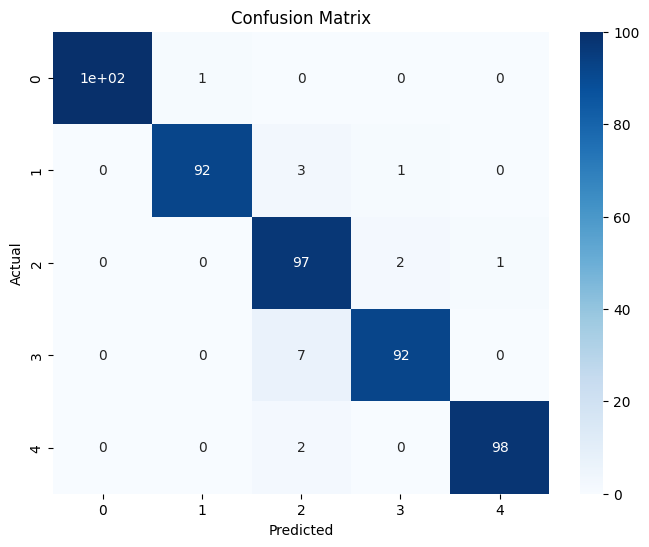

In [15]:
conf_matrix = confusion_matrix(y_true,y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix,annot=True,cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

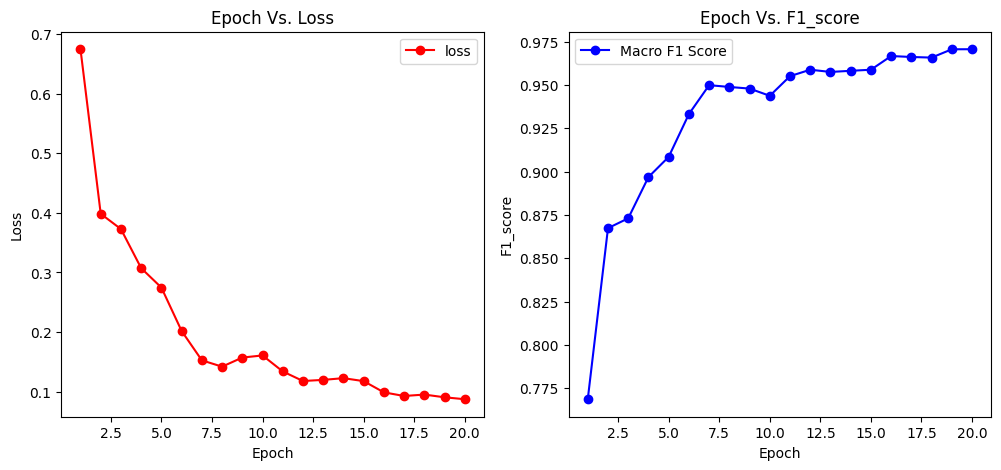

In [16]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1,num_epochs+1),epoch_loss,marker="o",linestyle='-',color='r',label="loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch Vs. Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,num_epochs+1),epoch_accuracy,marker="o",linestyle='-',color='b',label="Macro F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1_score")
plt.title("Epoch Vs. F1_score")
plt.legend()

plt.show()

In [17]:
def preprocess_images(image):
    transform = transforms.Compose([
    transforms.RandomResizedCrop((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225])

    ])

    return transform(image).unsqueeze(0)

In [18]:
CLASS_NAMES = ["baso","eosi","lymp","mono","neut"]

In [19]:
def predict(image_path,model=model):
    image = Image.open(image_path).convert("RGB")
    processed_images = preprocess_images(image)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    processed_images = processed_images.to(device)

    with torch.no_grad():
        output = model(processed_images)
        _, predicted_class = torch.max(output,1)

    return predicted_class
    # return CLASS_NAMES[predicted_class.item()]

In [20]:
# path = "/kaggle/input/immunoquest1/Dataset/Dataset/test/img1.jpg"
# predict(path)
result_ID = []
result_label = []

for i in range(1,51):
    path = f"/kaggle/input/immunoquest1/Dataset/Dataset/test/img{i}.jpg"
    result_ID.append(f"img{i}")
    result_label.append(int(predict(path).item()))

In [21]:
df = pd.DataFrame(result_ID,columns=['Id'])

In [22]:
df['Label'] = result_label 

In [23]:
df.to_csv("submission.csv",index=False)

In [24]:
pd.read_csv("submission.csv")

,Id,Label
0,img1,4
1,img2,3
2,img3,4
3,img4,4
4,img5,4
5,img6,4
6,img7,4
7,img8,4
8,img9,4
9,img10,4
